# EBAC - Regressão II - regressão múltipla

#### Previsão de renda

Vamos trabalhar com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [1]:
# Carrega as bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector

%matplotlib inline

# Checa a integridade da base de dados

In [2]:
# Checa se há dados faltantes

def missing_values(df) -> None:
    
    
    if True in df.isna().any().to_list():
        print('Porcentagem de valores faltantes nas seguintes colunas: \n')
        missing_perc = 100 * df.isna().mean()
        print(missing_perc)
    else:
        print('Não há valores faltantes.')
    
    return None

# checa se há duplicatas

def duplicated_values(df) -> None:
    
    
    if df.shape[0] == df.drop_duplicates().shape[0]:
        print('Não há duplicatas. \n')
    else:
        num_duplicates = df.duplicated().sum()
        print(f'Número de duplicatas: {num_duplicates}')
        print(f'Porcentagem de dados únicos: {round(100*(1-num_duplicates/df.shape[0]), 2)}% \n')
    
    
    return None

# confere o tipo de dados presentes na base pré-tratamento

def data_type(df) -> None:
    
    print(f'Shape: {df.shape} \n')
    
    # Seleciona colunas numéricas
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
    print('\nColunas numéricas:')
    print(f'{num_cols}\n')
    
    # Seleciona colunas categóricas
    cat_cols = df.select_dtypes(include=['object', 'category', 'datetime64[ns]']).columns.to_list()
    print('\nColunas categóricas:')
    print(f'{cat_cols} \n')
    
    # Seleciona colunas bool
    bool_cols = df.select_dtypes(include=['bool']).columns.to_list()
    print('\nColunas booleanas:')
    print(f'{bool_cols} \n')
    
    
    return None

# função que chama as funções acima

def checking_base(df) -> None:
    
    
    data_type(df)
    
    print('Checagem de duplicatas:')
    duplicated_values(df)
     
    missing_values(df)
    
    return None

In [3]:
# carrega a base de dados

df = pd.read_csv('previsao_de_renda.csv')

In [4]:
checking_base(df)

Shape: (15000, 15) 


Colunas numéricas:
['Unnamed: 0', 'id_cliente', 'qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']


Colunas categóricas:
['data_ref', 'sexo', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'] 


Colunas booleanas:
['posse_de_veiculo', 'posse_de_imovel'] 

Checagem de duplicatas:
Não há duplicatas. 

Porcentagem de valores faltantes nas seguintes colunas: 

Unnamed: 0                0.000000
data_ref                  0.000000
id_cliente                0.000000
sexo                      0.000000
posse_de_veiculo          0.000000
posse_de_imovel           0.000000
qtd_filhos                0.000000
tipo_renda                0.000000
educacao                  0.000000
estado_civil              0.000000
tipo_residencia           0.000000
idade                     0.000000
tempo_emprego            17.153333
qt_pessoas_residencia     0.000000
renda                     0.000000
dtype: float64


In [5]:
# drop os valores missing referentes ao trabalho e removendo as colunas desnecessárias
# a coluna 'sexo' é removida para respeitar a igualdade entre os sexos
df.dropna(inplace=True)
df.drop(columns=['Unnamed: 0', 'data_ref', 'id_cliente', 'sexo'], inplace=True)

In [6]:
# checando novamente
checking_base(df)

Shape: (12427, 11) 


Colunas numéricas:
['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']


Colunas categóricas:
['tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia'] 


Colunas booleanas:
['posse_de_veiculo', 'posse_de_imovel'] 

Checagem de duplicatas:
Número de duplicatas: 3772
Porcentagem de dados únicos: 69.65% 

Não há valores faltantes.


# Definição das funções para os modelos OLS, Ridge, LASSO e Árvore de Regressão

In [7]:
# cria a função para ajustar o modelo ridge
def modelo_ridge(formula: str, df: pd.DataFrame) -> None:
    
    
    # inicia o patsy dmatrices
    y, X = patsy.dmatrices(formula, data=df)
    # aqui, separando o modelo entre teste e treino em 25%/75%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # cria um vetor com os valores de alpha
    alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

    for alpha in alphas:
        # carrega o modelo Ridge
        model_ridge = Ridge(alpha=alpha)

        # 'fita' o modelo
        result_ridge = model_ridge.fit(X_train, y_train)

        # mostra o resumo do modelo
        print(f"Alpha: {alpha}")
        print(f"R-squared (train): {result_ridge.score(X_train, y_train):.3f}")
        print(f"R-squared (test): {result_ridge.score(X_test, y_test):.3f}")
        
    return None

In [8]:
# cria a função para ajustar o modelo LASSO
def modelo_lasso(formula: str, df: pd.DataFrame) -> None:
    
    
    # inicia o patsy dmatrices
    y, X = patsy.dmatrices(formula, data=df)
    # aqui, separando o modelo entre teste e treino em 25%/75%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # cria um vetor com os valores de alpha
    alphas = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]

    for alpha in alphas:
        # carrega o modelo LASSO
        model_lasso = Lasso(alpha=alpha, max_iter=10000)

        # 'fita' o modelo
        result_lasso = model_lasso.fit(X_train, y_train)

        # mostra o resumo do modelo
        print(f"Alpha: {alpha}")
        print(f"R-squared (train): {result_lasso.score(X_train, y_train):.3f}")
        print(f"R-squared (test): {result_lasso.score(X_test, y_test):.3f}")
        
    return None


In [9]:
# cria a função para ajustar o modelo OLS

def modelo_ols(formula: str, df: pd.DataFrame) -> None:
    
    # inicia o patsy dmatrices
    y, X = patsy.dmatrices(formula, data=df)
    # aqui, separando o modelo entre teste e treino em 25%/75%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # transforma em pd.Dataframe, afim de calcular o resíduo
    X_test = pd.DataFrame(X_test, columns=X.design_info.column_names)
    y_test = pd.DataFrame(y_test, columns=['renda'])

    # carrega o modelo OLS
    model_ols = sm.OLS(y_train, X_train)
    # 'fita' o modelo
    result_ols = model_ols.fit()
    print(result_ols.summary())
    
    # calculando os valores previstos
    y_pred = result_ols.predict(X_test)

    # adicionando a coluna np.log(renda)
    y_test['log_renda'] = np.log(y_test['renda'])
    y_res = y_test['renda'] - y_test['log_renda']

    # plotando o grafico para os residuos
    sns.residplot(x=y_pred, y=y_res, color='g')
    plt.title('Gráfico de Resíduos')
    plt.xlabel('y residual')
    plt.ylabel('y testes')
    plt.show()
    
    return None

In [10]:
def decision_tree(df: pd.DataFrame) -> None:
    
    
    arvore_reg = DecisionTreeRegressor(random_state=42)
    # define os parametros de busca
    param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4]
}

    # cria um objeto gridsearch
    arvore_grid_search = GridSearchCV(arvore_reg, param_grid, cv=5, scoring='r2')

    # separa o modelo entre teste e treino em 25%/75%
    X_train, X_test, y_train, y_test = train_test_split(df.drop('renda', axis=1), 
                                                        df['renda'], test_size=0.25, 
                                                        random_state=42)
    # fit realiza a busca para a arvore
    arvore_grid_search.fit(X_train, y_train)

    # obtencao dos melhores parametros
    melhores_params = arvore_grid_search.best_params_

    # fita a arvore com os melhores parametros
    arvore_reg = DecisionTreeRegressor(random_state=42, **melhores_params)
    arvore_reg.fit(X_train, y_train)

    # faz predicoes para o melhor conjunto
    y_pred = arvore_reg.predict(X_test)

    # Calcula R-quadrado
    r2 = r2_score(y_test, y_pred)

    print(f'Melhores parametros: {melhores_params}')
    print(f'Melhor R-quadrado (teste): {r2:.3f}')
    
    return None

In [11]:
# função principal que invoca os modelos


def modelos_regression(formula: str, df: pd.DataFrame) -> None:
    
    print('OLS')
    modelo_ols(formula, df)
    print('')
    
    print('RIDGE')
    modelo_ridge(formula, df)
    print('')
    
    print('LASSO')
    modelo_lasso(formula, df)
    print('')
    
    print('Árvore de Decisão')
    decision_tree(df)    
    print('')
    
    return None

# Análise da base de dados

In [12]:
# criando as variáveis dummies para serem usadas pelo patsy
df_dummies = pd.get_dummies(data=df,
                         columns=['tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia','posse_de_veiculo', 'posse_de_imovel'],
                         drop_first=True)

# renomeia as colunas para melhor vizualização
df_dummies = df_dummies.rename(columns=lambda x: x.replace(' ', '_'))
df_dummies = df_dummies.rename(columns=lambda x: x.replace('á', 'a').replace('ç', 'c').replace('ã', 'a').replace('ó', 'o').replace('ú', 'u'))

# conta a frequencia das colunas para usar de casela
column_frequencies = {}
for col in df_dummies.columns:
    counts = df_dummies[col].value_counts()
    column_frequencies[col] = counts.iloc[0] if not counts.empty else 0

sorted_columns = sorted(column_frequencies, key=column_frequencies.get, reverse=True)
df_dummies = df_dummies[sorted_columns]

print('Ordem de Casela das colunas:')
for index,col in enumerate(df_dummies.columns):
    print(index+1,col)

Ordem de Casela das colunas:
1 tipo_renda_Bolsista
2 tipo_renda_Pensionista
3 educacao_Pos_graduacao
4 tipo_residencia_Comunitario
5 tipo_residencia_Estudio
6 estado_civil_Viuvo
7 tipo_residencia_Governamental
8 educacao_Superior_incompleto
9 tipo_residencia_Com_os_pais
10 estado_civil_Separado
11 estado_civil_Uniao
12 tipo_renda_Servidor_publico
13 tipo_residencia_Casa
14 estado_civil_Solteiro
15 tipo_renda_Empresario
16 posse_de_imovel_True
17 qtd_filhos
18 educacao_Superior_completo
19 posse_de_veiculo_True
20 educacao_Secundario
21 qt_pessoas_residencia
22 idade
23 tempo_emprego
24 renda


In [13]:
# formula de acordo com a aparicao das colunas
formula_1 = ('np.log(renda) ~ tipo_renda_Bolsista + tipo_renda_Pensionista + '
           'educacao_Pos_graduacao + tipo_residencia_Comunitario + '
           'tipo_residencia_Estudio + estado_civil_Viuvo + '
           'tipo_residencia_Governamental + '
           'educacao_Superior_incompleto + tipo_residencia_Com_os_pais + '
           'estado_civil_Separado + estado_civil_Uniao + '
           'tipo_renda_Servidor_publico + tipo_residencia_Casa + '
           'estado_civil_Solteiro + tipo_renda_Empresario + '
           'posse_de_imovel_True + qtd_filhos + '
           'educacao_Superior_completo + posse_de_veiculo_True + '
           'educacao_Secundario + qt_pessoas_residencia + idade + '
           'tempo_emprego -1')

formula_2 = ('np.log(renda) ~'
           '+ tipo_residencia_Estudio + estado_civil_Viuvo'
           '+ educacao_Superior_incompleto + tipo_residencia_Com_os_pais'
           '+ estado_civil_Separado'
           '+ estado_civil_Solteiro + tipo_renda_Empresario'
           '+ posse_de_imovel_True + qtd_filhos'
           '+ educacao_Superior_completo + posse_de_veiculo_True'
           '+ educacao_Secundario + qt_pessoas_residencia + idade'
           '+ tempo_emprego -1')

formula_3 = ('np.log(renda) ~'
           '+ posse_de_imovel_True + qtd_filhos'
           '+ posse_de_veiculo_True'
           '+ qt_pessoas_residencia + idade'
           '+ tempo_emprego -1')

formulas = [formula_1, formula_2, formula_3]

### Para as formulas acima, os modelos serao avaliados.

Formula utilizada: 
np.log(renda) ~ tipo_renda_Bolsista + tipo_renda_Pensionista + educacao_Pos_graduacao + tipo_residencia_Comunitario + tipo_residencia_Estudio + estado_civil_Viuvo + tipo_residencia_Governamental + educacao_Superior_incompleto + tipo_residencia_Com_os_pais + estado_civil_Separado + estado_civil_Uniao + tipo_renda_Servidor_publico + tipo_residencia_Casa + estado_civil_Solteiro + tipo_renda_Empresario + posse_de_imovel_True + qtd_filhos + educacao_Superior_completo + posse_de_veiculo_True + educacao_Secundario + qt_pessoas_residencia + idade + tempo_emprego -1 

OLS
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          3.997e+04
Date:                Tue, 11 Apr 2023   Prob (F-statistic)

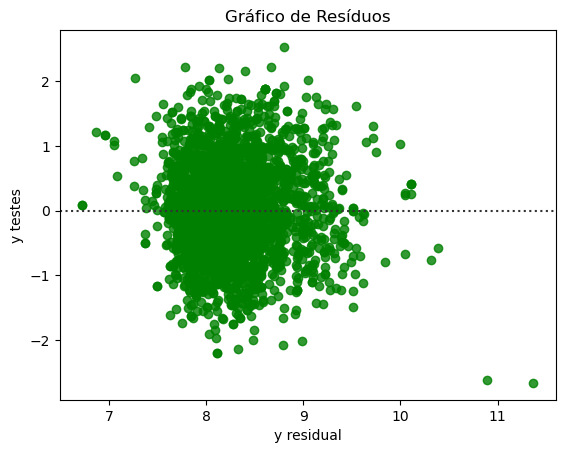


RIDGE
Alpha: 0
R-squared (train): 0.203
R-squared (test): 0.219
Alpha: 0.001
R-squared (train): 0.203
R-squared (test): 0.219
Alpha: 0.005
R-squared (train): 0.203
R-squared (test): 0.219
Alpha: 0.01
R-squared (train): 0.203
R-squared (test): 0.219
Alpha: 0.05
R-squared (train): 0.203
R-squared (test): 0.219
Alpha: 0.1
R-squared (train): 0.203
R-squared (test): 0.219

LASSO
Alpha: 0.0001
R-squared (train): 0.203
R-squared (test): 0.220
Alpha: 0.001
R-squared (train): 0.202
R-squared (test): 0.219
Alpha: 0.005
R-squared (train): 0.200
R-squared (test): 0.217
Alpha: 0.01
R-squared (train): 0.198
R-squared (test): 0.215
Alpha: 0.05
R-squared (train): 0.179
R-squared (test): 0.188
Alpha: 0.1
R-squared (train): 0.169
R-squared (test): 0.174

Árvore de Decisão
Melhores parametros: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor R-quadrado (teste): 0.203

Formula utilizada: 
np.log(renda) ~+ tipo_residencia_Estudio + estado_civil_Viuvo+ educacao_Superior_incompleto + t

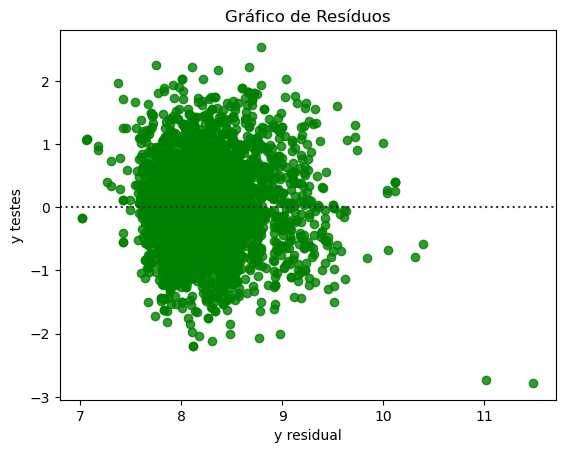


RIDGE
Alpha: 0
R-squared (train): 0.201
R-squared (test): 0.220
Alpha: 0.001
R-squared (train): 0.201
R-squared (test): 0.220
Alpha: 0.005
R-squared (train): 0.201
R-squared (test): 0.220
Alpha: 0.01
R-squared (train): 0.201
R-squared (test): 0.220
Alpha: 0.05
R-squared (train): 0.201
R-squared (test): 0.220
Alpha: 0.1
R-squared (train): 0.201
R-squared (test): 0.220

LASSO
Alpha: 0.0001
R-squared (train): 0.201
R-squared (test): 0.220
Alpha: 0.001
R-squared (train): 0.200
R-squared (test): 0.219
Alpha: 0.005
R-squared (train): 0.199
R-squared (test): 0.217
Alpha: 0.01
R-squared (train): 0.198
R-squared (test): 0.215
Alpha: 0.05
R-squared (train): 0.179
R-squared (test): 0.188
Alpha: 0.1
R-squared (train): 0.169
R-squared (test): 0.174

Árvore de Decisão
Melhores parametros: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor R-quadrado (teste): 0.203

Formula utilizada: 
np.log(renda) ~+ posse_de_imovel_True + qtd_filhos+ posse_de_veiculo_True+ qt_pessoas_residenci

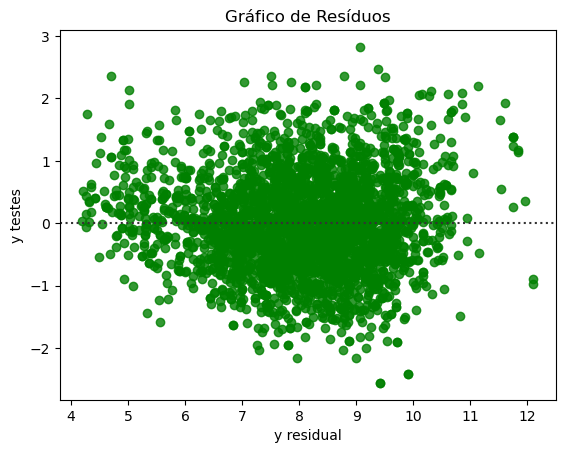


RIDGE
Alpha: 0
R-squared (train): 0.195
R-squared (test): 0.215
Alpha: 0.001
R-squared (train): 0.195
R-squared (test): 0.215
Alpha: 0.005
R-squared (train): 0.195
R-squared (test): 0.215
Alpha: 0.01
R-squared (train): 0.195
R-squared (test): 0.215
Alpha: 0.05
R-squared (train): 0.195
R-squared (test): 0.215
Alpha: 0.1
R-squared (train): 0.195
R-squared (test): 0.215

LASSO
Alpha: 0.0001
R-squared (train): 0.195
R-squared (test): 0.215
Alpha: 0.001
R-squared (train): 0.195
R-squared (test): 0.214
Alpha: 0.005
R-squared (train): 0.195
R-squared (test): 0.214
Alpha: 0.01
R-squared (train): 0.194
R-squared (test): 0.212
Alpha: 0.05
R-squared (train): 0.179
R-squared (test): 0.188
Alpha: 0.1
R-squared (train): 0.169
R-squared (test): 0.174

Árvore de Decisão
Melhores parametros: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor R-quadrado (teste): 0.203



In [14]:
for formula in formulas:
    print(f'Formula utilizada: \n{formula} \n')
    modelos_regression(formula, df_dummies)

# Conclusões

A eliminação da maioria das variáveis tornou o modelo mais simples e com um poder preditivo tão bom quanto o ajuste com todas as variáveis. Para considerar a qualidade do modelo foi levada em consideração a distribuição dos resíduos e o fator R².

Logo, as variáveis significativas que podem vir a explicar o modelo de previsão de renda são:
* Posse de imóvel
* Quantidade de filhos
* Posse de Véiculo
* Quantidade de pessoas por residência
* Idade
* Tempo de emprego

Fazendo o ajuste de retirar o 'interceptor' da regressão linear (adicionando o -1), o R² fica 0.97 para um modelo mais simples e o padrão residual fica bem distríbuido.
Se o interceptor for retirado, o R² da regressão linear cai para 0.20, se igualando ao dos outros métodos usados acima.
A principal diferença entre os modelos provém da maneira que ocorre a regularização. No caso do fit.OLS, esta não existe. Para os casos de LASSO e Ridge, a regularização difere pelas normas, L1 e L2, respectivamente. E, claro, pelo hiperfator alpha que controla a capacidade de generalização do sistema. Isto é visto pelo fator R² conforme alpha cresce. É possível notar que para o LASSO, R² cai com o aumento de alpha, indicando que a forte regularização não favorece a análise. Tal tendência não é vista no modelo Ridge.

Em geral, a árvore de regressão perfoma melhor que os outros métodos, se for desconsirado a retirada do interceptor. Havendo a exclusão do interceptor pelo modelo OLS, a árvore não é indicada.